# Averging, Filtering and Low Passing Data

VTools provides simple methods for period averaging, filtering and low passing data, particularly tidal data. Basic period averaging and in pareticular daily averaging is easily covered by the regular Pandas API, but can yield unepected results with missing data. Several other tide-compatible filters are available.

Let's start by making a single time series with period 12.4 hours. This 

Text(0, 0.5, 'm')

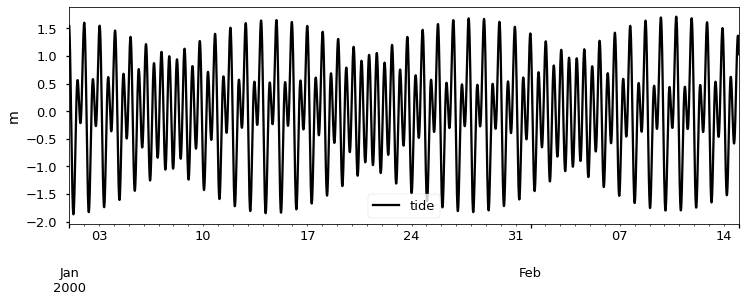

In [11]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.signal
from vtools.data.vtime import minutes,days,months
from vtools.functions.period_op import period_op
plt.style.use(['seaborn-colorblind','seaborn-talk'])
mpl.rcParams['figure.figsize'] = [12,4.]

delta_t = minutes(15)  # creating a real offset instead of a string because it will be used in algebra shortly
ndx = pd.date_range("2000-01-01","2000-02-15",freq=delta_t)
thours = 0.25*np.arange(len(ndx))
twopi = 2.*np.pi
M2 = np.cos(twopi*thours/12.4)
K1 = 0.5*np.cos(twopi*thours/23.9+1.)
O1 = 0.5*np.cos(twopi*thours/25.8+1.)
tide = M2 + O1 + K1
df = pd.DataFrame(index=ndx,data={"tide": tide})
ax=df.plot(color="black")
ax.set_ylabel("m")






Now let's work on averaging or filtering the data. create several versions of a daily average on these values. Note that a reasonable/desired outcome is just a line at zero. 

One approach is a 24-hour boxcar average. A boxcar average is one that puts the same weight in all the points in the window. This is not really a daily average because it is a moving window. The output is defined/recalculated at each the original 15min points. The timing won't be centered perfectly even if you calculate the average with the "center" option, because there are an even number of samples in 24 hours. Note that in anticipation of missing data in a real signal, the `min_periods` argument is used and set to a number fairly close to the 96 samples per day.

A true daily average results in one value per day. Pandas can do this with `df.resample('D').mean()`. The time part of the result won't have meaning in this case and you have to consider whether to do something with the index. You also have to watch out for missing data and boundary effects. Pandas may attempt to complete the average with just a few values even though this can cause absurd values near data boundaries or missing data. An example is showin in the plot below, and the value is so bad it had to be truncated. The vtools `period_op` allows you to specify the fraction of allowed missing data which should be set fairly low, say between 0.0 and 0.1. The fact that Pandas doesn't have a switch for this is uncharacteristic -- they  often have arguments in their interfaces (like min_periods for `rolling()` operations) that will help you specify a minimum number of data.  

Finally, note that the boxcar and daily average are related. A daily average can be thought of as a boxcar that is resampled once per day and then has its timestamp shifted from the middle of the period to the beginning (or sometimes the end) of the period. We've added markers to the VTools daily average to show how daily averages relate to the boxcar. Each green point is a snapshot of the blue boxcar shifted ~12 hours to the left. Sampling the wiggles once per 24 hours causes something called "aliasing" where a much lower frequency (14-day signal) is caused by visiting the tidal wiggles once per day in different places in the tide cycle. The main point to keep in mind here is that we've added a apparent content ... and yes, we've seen these spurious signals analyzed as if they were real.



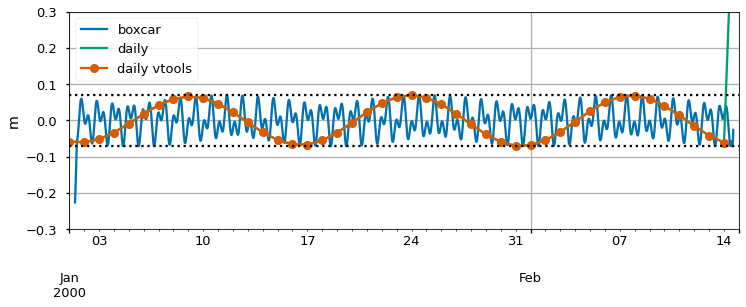

In [12]:
samples_day = 96
box = df.rolling(samples_day,center=True,min_periods=85).mean()
daily = df.resample('D').mean()
daily_vtools = period_op(df,period = "D",agg="mean",max_absent_frac=0.)

ax = box.plot()
daily.plot(ax=ax)
daily_vtools.plot(ax=ax,style=['-o'])
ax.grid()
ax.set_ylim(-0.3,0.3)
ax.axhline(y=-0.07,color="black",linestyle=":")
ax.axhline(y=0.07,color="black",linestyle=":")
ax.set_ylabel('m')

plt.legend(["boxcar","daily","daily vtools"])
plt.show()

Next comes the all-important question: how much do the wiggles matter? Importance depends on the signal and the context of the analysis, but in a predictable way. The strength of the wiggles will be about 5% of the tidal range of the original signal. In the present case that was a bit over 1.5m. The size of the wiggles is thus about 0.07m. To show that, a dotted line is drawn at +/- 0.07m on the plot.

If you are trying to filter discharge at Rio Vista on the Sacramento River, the tides have an amplitude of 150,000cfs and the mean signal you are trying to extract could be as amall as 3,000cfs during a dry summer. Using the 5% rule, the spurious wiggles will be 7,500cfs, and will dominate your analysis. Even worse -- it will look real and it will seem like a spring-neap effect. For water levels, the situation would be less bad. At Rio Vista, the tidal amplitude is perhaps 1m, so the filter wiggles will be about 5cm -- detectable but not dominant compared to the 1.5m worth of variation in water levels at that station seasonally or in flood events. Similarly, signal processing errors are often not the biggest weakness in a salinity analysis. If you are analyzing fluxes, however, it is recommended that you use a better filter. 

# Filters
So we have some issues because we are trying to use calendar/solar day tools on a tide that is largely lunar in nature. simplest filter you could use in the above case is a boxcar that is more tuned to the 25.8 lunar period. This would be implemented using an averaging period of 25 values for hourly data or 99 15 minute samples. In the code below I've been a bit fussier about the required data, allowing no misisng data and avoiding the "crazy" values at the end. As you can see from the blue and orange lines,the issues are reduced in the fillowing plot by half. 

We can go a bit further and use a real tidal filter. These filters are like moving averages, but their weights are not equal like a boxcar filter. Below are a couple examples. One is the so-called "Godin" filter which gained popularity because it could be constructed from successive boxcar ingredients -- one 25 hour boxcar that is centered on the time point under analysis and two 24 hour boxcars that are staggered to the left and right by one sample so that overall they produce a centered effect.

The last filter is a cosine_lanczos. More specifically it is a filter with a Lanczos window built around a 40 hour cutoff frequency that is "squared" in the sense that it is applied forward and backward which produces a phase-neutral response and increases the effective order of the filtration.

Note that both the Godin and cosine-Lanczos filters produce an almost entirely flat response. Both have completely supressed the tide. We'll worry in a few moments about what good things they may have suppressed as well. As a practical matter, note that the Godin line has fewer missing values at the beginning and end of the series than the cosine-Lanczos. This is because it is a shorter filter that has non-zero weights over a briefer period. Tidal filters often produce nans at the beginning and end of the data set


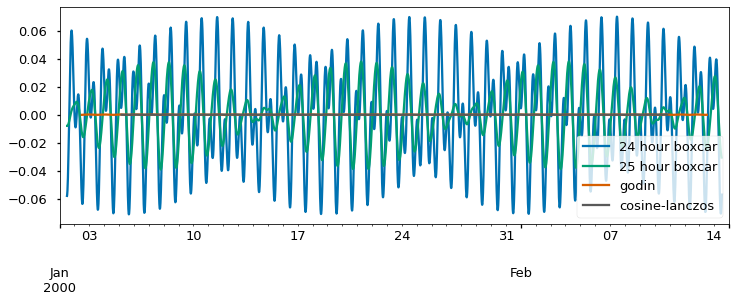

In [13]:
from vtools.functions.filter import godin,cosine_lanczos
samples_tidal_day = 99
box24 = df.rolling(samples_day,center=True,min_periods=96).mean()
box25 = df.rolling(samples_tidal_day,center=True,min_periods=99).mean()
gdn = godin(df)
coslan = cosine_lanczos(df,'40H')
ax1 = box24.plot()
box25.plot(ax=ax1)
gdn.plot(ax=ax1)
coslan.plot(ax=ax1,color="0.35")
ax1.legend(['24 hour boxcar','25 hour boxcar','godin','cosine-lanczos'])

So at this point we've tested the ability of the filters to eliminate the tides, their so-called stopband characteristics. Now what about their ability to capture or "pass" the lower frequencies that are of interest. For this we need to add a subtidal (slow varying) component to the tide. To do this we will use a function called a "chirp" which transitions from a period of 12 days to a period of 4 days -- in both cases much longer than a tidal day.

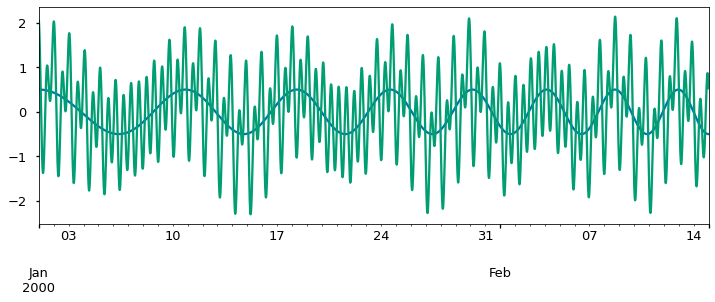

In [14]:

# Create the chirp and show it.
f0=1./(24.*12.)
f1=1./(24.*4)
subtide = 0.5*scipy.signal.chirp(thours, f0, thours[-1], f1, method='linear', phi=0, vertex_zero=True)
dfsub = pd.DataFrame(index=df.index,data=subtide)
ax=dfsub.plot()


# Add it to the original tide
df_with_sub = df.squeeze() + dfsub.squeeze()
df_with_sub = df_with_sub.to_frame()
df_with_sub.plot(ax=ax)
ax.get_legend().remove()
plt.show()

Now we attempt to extract the known subtidal signals using some of the tidal averages and filters. Doing so reveals differences that may be significant in some applications. The Godin filter attenuates signals with periods of 3-7 days by as much as 30%. The 25-hour boxcar (which is one of the "ingredients" of the Godin filter) attenuates less, but adds wiggles. The cosine-Lanczos filter is better in both regards, but as we have already mentioned it amplifies gaps and boundary effects. One useful step to help minimize this is to interpolate small gaps before applying the filter. The way to do this is shown in the first step in the followoing snippet, but of course it wouldn't do anything here because there is no missing data.

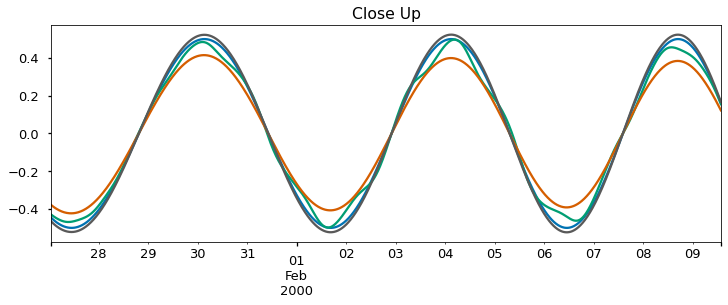

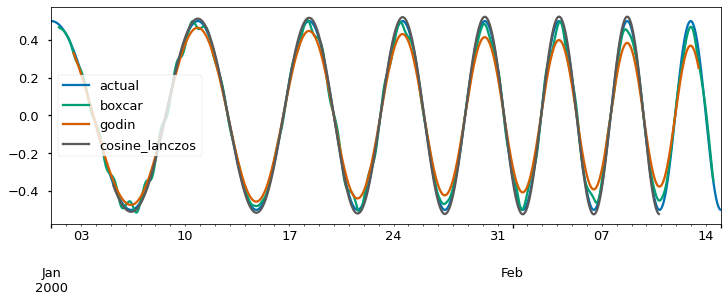

In [15]:
# Linear by default, this will leave any gaps longer than 4 samples. In this case there is none so this does nothing.
df_with_sub = df_with_sub.interpolate(limit=4)  

box25 = df_with_sub.rolling(99,center=True).mean()   # Boxcar spanning 99 15min values
gdnsub = godin(df_with_sub)                          # Godin
cl_sub = cosine_lanczos(df_with_sub,'40H')           # cosine-Lanzos squared

ax1=dfsub.iloc[2500:3800].plot()
box25.iloc[2500:3800].plot(ax=ax1)
gdnsub.iloc[2500:3800].plot(ax=ax1)
cl_sub.iloc[2500:3800].plot(ax=ax1,color="0.35")


ax=dfsub.plot()
box25.plot(ax=ax)
gdnsub.plot(ax=ax)
cl_sub.plot(ax=ax,color="0.35")
ax.legend(["actual","boxcar","godin","cosine_lanczos"])
ax1.set_title("Close Up")
ax1.get_legend().remove()


plt.show()

VTools also provides a convenient interface to the Butterworth filter. However, Butterworth filters are members of the class of "infinite impulse response" filters. These are kind of hard to use and we are obviously at the point of decreasing return, so these are not covered here in detail. There are good reasons to stick with finite length filters, both in terms of practical usage and locality of the filter.
